# Step 4: ML Modeling and Model Comparison

## Introduction: Overview of Data Science Problem
With the current population of London at around 9,648,000, and a trend of ~1-1.5% population increase per year over the past few years1, the importance of urban design has become an important consideration for the city’s urban planning commissions. Over the past few years, London’s local government has been making a push for “greening London”; the London Plan 2021 outlines an integrated environmental strategy for increasing urban greenspace, as well as improving air quality and mitigating the effects of climate change. <br>
<br>
The focus of this project is on developing a model to predict which factors, including access to urban greenspace, are most important for predicting longevity within the London boroughs. I will use data from the London Ward Well-Being Scores dataset, collected by the Greater London Authority over the period of 2009-2013. This dataset includes information on life-expectancy, as well as 12 different well-being indicators such as childhood obesity rates, crime rates, unemployment rates, and access to greenspace and public transport. 

### Load Data and Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import warnings
warnings.filterwarnings('ignore')


In [86]:
# Import updated dataframe
datapath = '/Users/kbrewitt/Github/Predicting Longevity Using Urban Greenspace/clean_data/'
df_longevity = pd.read_csv(datapath + 'Longevity_DF.csv', index_col=0)


In [87]:
# Check imported data
df_longevity.info()
#df_longevity.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3275 entries, 0 to 3274
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Borough                      3275 non-null   object 
 1   Life_Expectancy              3275 non-null   float64
 2   Childhood_Obesity            3275 non-null   float64
 3   Incapacity_Benefit           3275 non-null   float64
 4   Unemployment                 3275 non-null   float64
 5   Crime                        3275 non-null   float64
 6   Deliberate_Fires             3275 non-null   float64
 7   GCSE_points                  3275 non-null   float64
 8   Unauthorised_School_Absence  3275 non-null   float64
 9   Dependent_children           3275 non-null   float64
 10  Public_Transport_Access      3275 non-null   float64
 11  Greespace_Access             3275 non-null   float64
 12  Greenspace_Surface_Area      3275 non-null   float64
 13  Total_Greenspace  

# 1. Final Preprocessing of Data
### 1a. Remove unwanted columns from model
I am removing the Borough column, since all the other metrics are of more interest in terms of explaining the health impacts of living in a particular Borough. I am also dropping redundant (colinear) metrics for total greenspace per Borough. 

In [88]:
# Drop Borough column
df_longevity = df_longevity.drop(columns=['Borough','Binned_Median_Greenspace','Ranked_Greenspace'])

# Define target (y-variable)
target_name = "Life_Expectancy"
target = df_longevity[target_name]

data = df_longevity.drop(columns=[target_name])

### 1b. Select columns based on data type (categorical vs numeric)

In [89]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)


In [90]:
# Create the preprocessors for the numerical and categorical columns 
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [91]:
# Create the transformer and associate each of these preprocessors with their respective columns
# This will split the data based on column type, process that column, and concatenate the columns back into a dataframe
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])


## 2. Train-test split data
Split the data into test and training sets before preprocessing.

In [92]:
data.shape

(3275, 12)

In [93]:
X_tr, X_te, y_tr, y_te = train_test_split(data, target,
                                                    test_size=0.3, 
                                                    random_state=43)

In [94]:
X_tr.shape, X_te.shape

((2292, 12), (983, 12))

In [95]:
y_tr.shape, y_te.shape

((2292,), (983,))

# 3. Applying ML Models
This is a regression problem in supervised machine learning. Here I have used the following regression models:

-- Linear Regression<br>
-- Random Forest <br>
-- Gradient Boosting Regressor<br>
-- Support Vector Regressor (SVR)<br>


## Model 1: Linear regression 
Fit a simple linear regression model using a pipeline.

In [13]:
# Make a pipeline for linear regression model
from sklearn.feature_selection import SelectKBest, f_regression

LRpipe = make_pipeline(preprocessor,
    SelectKBest(),
    LinearRegression()
)

In [14]:
#  Pass the pipe object and use 5-fold cross-validation to assess fit on training data
lr_default_cv_results = cross_validate(LRpipe, X_tr, y_tr, cv=5)

In [15]:
# Assess basic linear regression model (default test score for linear regression is r-squared)
lr_cv_scores = lr_default_cv_results['test_score']
np.mean(lr_cv_scores), np.std(lr_cv_scores)

(0.5494834600459377, 0.02770005281159515)

### Use GridSearchCV for selecting k best parameters in the regression model
Note: There are no hyperparameters to tune in the basic lr model. 

In [40]:
#LRpipe.get_params().keys()

In [17]:
# GridSearchCV 
# Create a range of k for selecting k-best features 
k = [k+1 for k in range(1,16)]
lr_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(LRpipe, param_grid=lr_params, cv=5, n_jobs=-1)

In [18]:
# Fit the regression model to training data
lr_grid_cv.fit(X_tr, y_tr)

/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('one-hot-encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Total_Greenspace']),
                                                                        ('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['Childhood_Obesity',
                                                                          'Incapacity_Benefit',
                                                                          'Unemployment',
                                                                          'Crime',
                                                                        

In [20]:
lr_grid_cv.best_params_

{'selectkbest__k': 13}

In [21]:
# Calculate mean r-squared score for plotting
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

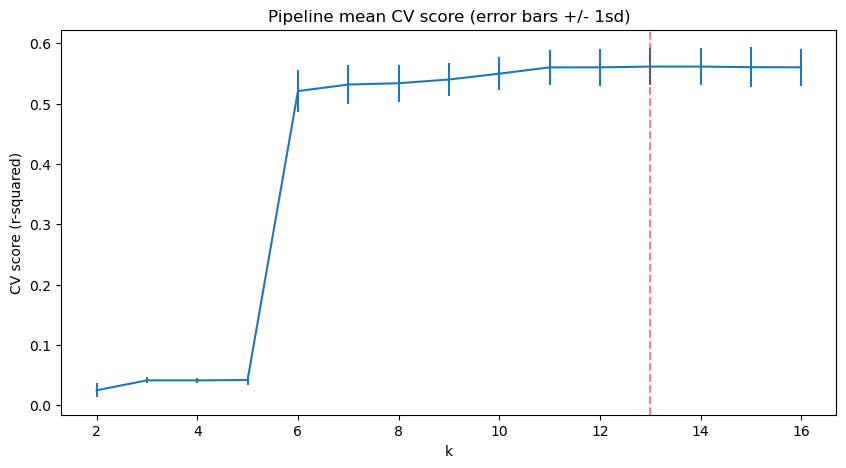

In [22]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']

# Plot the values of CV scores across values of k
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Use cross-validation to fit model using best value of k

In [23]:
# Fit model to training data using best k and cross-validation
lr_cv = cross_validate(lr_grid_cv.best_estimator_, X_tr, y_tr, 
                            scoring=['r2','neg_root_mean_squared_error'], cv=5, n_jobs=-1)


/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/kbrewitt/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


In [24]:
# Assess r-squared values for model using cross-validated training data
r2score_lr_train = np.mean(lr_cv['test_r2'])
mae_lr_train = -np.mean(lr_cv['test_neg_root_mean_squared_error'])

print('Mean r-squared for training data: ', r2score_lr_train)
print('Mean MAE for training data: ', mae_lr_train)

Mean r-squared for training data:  0.5612457340973179
Mean MAE for training data:  1.5431446863270695


In [81]:
# Get r-squared score for test data
r2score_lr_test = r2_score(y_te, lr_grid_cv.best_estimator_.predict(X_te))
mae_lr_test = mean_absolute_error(y_te, lr_grid_cv.best_estimator_.predict(X_te))

print('Mean r-squared for test data:', r2score_lr_test)
print('Mean MAE for test data:', mae_lr_test)

Mean r-squared for test data: 0.5419035014468032
Mean MAE for test data: 1.231804640623877


This is not a great r-squared score for either the train or test data. 

## Model 2: Random Forest Regression Model

In [83]:
# Define the model
from sklearn.ensemble import RandomForestRegressor

# Create a pipeline 
RFpipe = make_pipeline(preprocessor,
    RandomForestRegressor(random_state=43)
)

In [84]:
# Fit model to training data and use cross-validation
rf_default_cv_results = cross_validate(RFpipe, X_tr, y_tr, cv=5)

In [85]:
# Assess basic linear regression model (default test score for linear regression is r-squared)
rf_cv_scores = rf_default_cv_results['test_score']

np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.6899438102174261, 0.029251211818207664)

### Hyperparameter tuning using cross-validation and GridSearchCV

In [93]:
# Create parameter grid for random forest hyperparameters
n_est = [100, 400, 700, 1000]
max_d = [3, 6, 10, 15]

rf_params = {
        'randomforestregressor__n_estimators': n_est,
        'randomforestregressor__max_depth': max_d,
        'randomforestregressor__max_features': ['auto', 'sqrt']
}

rf_params

{'randomforestregressor__n_estimators': [100, 400, 700, 1000],
 'randomforestregressor__max_depth': [3, 6, 10, 15],
 'randomforestregressor__max_features': ['auto', 'sqrt']}

In [94]:
#RFpipe.get_params().keys()

In [95]:
# Call GridSearchCV with the random forest pipeline passing in the above grid_params
rf_grid_cv = GridSearchCV(RFpipe, param_grid=rf_params, cv=5, n_jobs=-1)

# Fit to training data
rf_grid_cv.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('one-hot-encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Total_Greenspace']),
                                                                        ('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['Childhood_Obesity',
                                                                          'Incapacity_Benefit',
                                                                          'Unemployment',
                                                                          'Crime',
                                                                        

In [96]:
# Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__max_depth': 15,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 1000}

#### Fit the model with the optimal hyperparameters (from GridSearchCV)

In [98]:
# Fit the best model to the training data
rf_cv = cross_validate(rf_grid_cv.best_estimator_, X_tr, y_tr,
                       scoring=['r2','neg_root_mean_squared_error'], cv=5, n_jobs=-1)


In [99]:
# Assess r-squared values for model using cross-validated training data
r2score_rf_train = np.mean(rf_cv['test_r2'])
mae_rf_train = -np.mean(rf_cv['test_neg_root_mean_squared_error'])

print('Mean r-squared for training data: ', r2score_rf_train)
print('Mean MAE for training data: ', mae_rf_train)

Mean r-squared for training data:  0.6903905442945028
Mean MAE for training data:  1.2955120226143866


In [100]:
# Get r-squared score for test data
r2score_rf_test = r2_score(y_te, rf_grid_cv.best_estimator_.predict(X_te))
mae_rf_test = mean_absolute_error(y_te, rf_grid_cv.best_estimator_.predict(X_te))

print('Mean r-squared for test data:', r2score_rf_test)
print('Mean MAE for test data:', mae_rf_test)

Mean r-squared for test data: 0.6902173064172661
Mean MAE for test data: 0.9896888543991714


### Hyperparameter tuning for random forest model using RandomSearchCV

In [101]:
from sklearn.model_selection import RandomizedSearchCV

# Create parameter grid for random forest hyperparameters 
n_est = range(100, 1000)
max_d = range(3, 20)

rf_params = {
        'randomforestregressor__n_estimators': n_est,
        'randomforestregressor__max_depth': max_d,
}

rf_params

{'randomforestregressor__n_estimators': range(100, 1000),
 'randomforestregressor__max_depth': range(3, 20)}

In [108]:
# Call RandomizedSearchCV with the random forest pipeline passing in the above grid_params
rf_rand_cv = RandomizedSearchCV(RFpipe, param_distributions=rf_params, n_iter=60, cv=5, n_jobs=-1)

# Fit to training data
rf_rand_cv.fit(X_tr, y_tr)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('one-hot-encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Total_Greenspace']),
                                                                              ('standard_scaler',
                                                                               StandardScaler(),
                                                                               ['Childhood_Obesity',
                                                                                'Incapacity_Benefit',
                                                                                'Unemployment',
                                                                                'Crime',
      

In [109]:
# Print the best params (`best_params_` attribute) from the grid search
rf_rand_cv.best_params_

{'randomforestregressor__n_estimators': 997,
 'randomforestregressor__max_depth': 19}

#### Fit the model with the optimal hyperparameters (from RandomizedSearchCV)

In [110]:
# Fit the best model to the training data
rf2_cv = cross_validate(rf_rand_cv.best_estimator_, X_tr, y_tr,
                       scoring=['r2','neg_root_mean_squared_error'], cv=5, n_jobs=-1)


In [111]:
# Assess r-squared values for model using cross-validated training data
r2score_rf_rand_train = np.mean(rf2_cv['test_r2'])
mae_rf_rand_train = -np.mean(rf2_cv['test_neg_root_mean_squared_error'])

print('Mean r-squared for training data: ', r2score_rf_rand_train)
print('Mean MAE for training data: ', mae_rf_rand_train)

Mean r-squared for training data:  0.6916154772935912
Mean MAE for training data:  1.2929388402121653


In [112]:
# Get r-squared score for test data
r2score_rf_rand_test = r2_score(y_te, rf_rand_cv.best_estimator_.predict(X_te))
mae_rf_rand_test = mean_absolute_error(y_te, rf_rand_cv.best_estimator_.predict(X_te))

print('Mean r-squared for test data:', r2score_rf_rand_test)
print('Mean MAE for test data:', mae_rf_rand_test)

Mean r-squared for test data: 0.6929389040211673
Mean MAE for test data: 0.9838259179037937


## Model 3: Gradient Boosting Regression Model

In [116]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a pipeline 
GBpipe = make_pipeline(preprocessor,
    GradientBoostingRegressor()
)


In [123]:
#GBpipe.get_params().keys()

In [127]:
gb_param = {
        'gradientboostingregressor__n_estimators' : [100,300,500],
        'gradientboostingregressor__max_depth': [5, 10, 15],
        'gradientboostingregressor__max_features': ['auto', 'sqrt'] 
        }

gb_grid_cv = GridSearchCV(GBpipe, param_grid = gb_param, cv=5, n_jobs= -1)
gb_grid_cv.fit(X_tr,y_tr)
print(gb_grid_cv.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Total_Greenspace']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Childhood_Obesity',
                                                   'Incapacity_Benefit',
                                                   'Unemployment', 'Crime',
                                                   'Deliberate_Fires',
                                                   'GCSE_points',
                                                   'Unauthorised_School_Absence',
                                                   'Dependent_children',
                                                   'Public_Transport_Access',
  

#### Fit the model with the optimal hyperparameters (from GridSearchCV)

In [131]:
# Fit the best model to the training data
gb_cv = cross_validate(gb_grid_cv.best_estimator_, X_tr, y_tr,
                       scoring=['r2','neg_root_mean_squared_error'], cv=5, n_jobs=-1)


In [132]:
# Assess r-squared values for model using cross-validated training data
r2score_gb_train = np.mean(gb_cv['test_r2'])
mae_gb_train = -np.mean(gb_cv['test_neg_root_mean_squared_error'])

print('Mean r-squared for training data: ', r2score_gb_train)
print('Mean MAE for training data: ', mae_gb_train)

Mean r-squared for training data:  0.7640237294981793
Mean MAE for training data:  1.131498720534894


In [134]:
# Get r-squared score for test data
r2score_gb_test = r2_score(y_te, gb_grid_cv.best_estimator_.predict(X_te))
mae_gb_test = mean_absolute_error(y_te, gb_grid_cv.best_estimator_.predict(X_te))

print('Mean r-squared for test data:', r2score_gb_test)
print('Mean MAE for test data:', mae_gb_test)

Mean r-squared for test data: 0.7752362246376756
Mean MAE for test data: 0.8222656758500797


## Model 4: Support Vector Regressor
The goal of SVR is to find a function that approximates the relationship between the input variables and a continuous target variable, while minimizing the prediction error.

In [143]:
# Import and fit the default model to the training data
from sklearn.svm import SVR

# Create a pipeline 
SVRpipe = make_pipeline(preprocessor,
    SVR(kernel = 'rbf')
)


### Hyperparameter tuning for SVR

In [ ]:
#SVRpipe.get_params().keys()

In [147]:
svr_param = {
        'svr__C': range(1,20),
        'svr__epsilon': np.linspace(0.1,2)
        }

#SVR_param

In [149]:
# Use RandomizedSearchCV to search for best hyperparameters (kernel=rbf)
svr_rand_cv = RandomizedSearchCV(SVRpipe, param_distributions = svr_param, cv=5, n_iter=60, n_jobs= -1)
svr_rand_cv.fit(X_tr,y_tr)

print(svr_rand_cv.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Total_Greenspace']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Childhood_Obesity',
                                                   'Incapacity_Benefit',
                                                   'Unemployment', 'Crime',
                                                   'Deliberate_Fires',
                                                   'GCSE_points',
                                                   'Unauthorised_School_Absence',
                                                   'Dependent_children',
                                                   'Public_Transport_Access',
  

#### Fit the model with the optimal hyperparameters

In [150]:
# Fit the best model to the training data using the rbf kernel
svr_cv = cross_validate(svr_rand_cv.best_estimator_, X_tr, y_tr, 
                        scoring=['r2','neg_root_mean_squared_error'], cv=5, n_jobs=-1)


In [151]:
# Assess r-squared values for model using cross-validated training data
r2score_svr_train = np.mean(svr_cv['test_r2'])
mae_svr_train = -np.mean(svr_cv['test_neg_root_mean_squared_error'])

print('Mean r-squared for training data: ', r2score_svr_train)
print('Mean MAE for training data: ', mae_svr_train)

Mean r-squared for training data:  0.6880017280351131
Mean MAE for training data:  1.3005400821084536


In [152]:
# Get r-squared score for test data
r2score_svr_test = r2_score(y_te, svr_rand_cv.best_estimator_.predict(X_te))
mae_svr_test = mean_absolute_error(y_te, svr_rand_cv.best_estimator_.predict(X_te))

print('Mean r-squared for test data:', r2score_svr_test)
print('Mean MAE for test data:', mae_svr_test)

Mean r-squared for test data: 0.6771677058123959
Mean MAE for test data: 0.9934171578972104


# 4. Model Comparison 
I applied different ML models above, tuned hyperparameters using GridSearchCV or RandomizedSearchCV, and evaluated their performances in terms of r-squared score for both the training and test data. I have compiled the scores below.

Clearly, the Random Forest and the Gradient Boost are the two best performing models. Both of the models are ensemble-based decision trees.

In [153]:
myLabels = [ 'Linear Regression','Random Forest','Gradient Boost', 'SVR']
score_test= [  r2score_lr_train, r2score_rf_train, r2score_gb_train, r2score_svr_train]
score_train= [ r2score_lr_test, r2score_rf_test, r2score_gb_test, r2score_svr_test ]

MAE_score = [mae_lr_test, mae_rf_test, mae_gb_test, mae_svr_test ]

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test, MAE_score)), 
               columns =['Algorithm', 'R-squared train score', 'R-squared test score' , 'MAE test score']) 

score_tab

,Algorithm,R-squared train score,R-squared test score,MAE test score
0,Linear Regression,0.541904,0.561246,1.231805
1,Random Forest,0.690217,0.690391,0.989689
2,Gradient Boost,0.775236,0.764024,0.822266
3,SVR,0.677168,0.688002,0.993417


Of the four models tested, the gradient boost regression model performs the best by far, even though it's accuracy is still not great. However, it does perform similarly on the train and test data, which is good. 

## 4a. Re-tune the Hyperparameters for the Gradient Boost Regression Model and Visualize the Results
Now that I've ascertained the best of the four models tested, I'm going to see if I can get it to perform better by tuning the hyperparameters again. Then we'll visualize the results.

In [165]:
# Create a pipeline 
GBpipe = make_pipeline(preprocessor,
    GradientBoostingRegressor(loss='absolute_error', max_features='sqrt')
)


#### Using GridSearchCV to tune hyperparameters:

In [167]:
# Using GridSearchCV to tune hyperparameters:
gb_param = {
        'gradientboostingregressor__n_estimators' : [100,500, 700],
        'gradientboostingregressor__max_depth': [5, 10, 15],
        }

gb_grid_cv = GridSearchCV(GBpipe, param_grid = gb_param, cv=5, n_jobs= -1)
gb_grid_cv.fit(X_tr,y_tr)
best_ests_grid = gb_grid_cv.best_estimator_
print(gb_grid_cv.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Total_Greenspace']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Childhood_Obesity',
                                                   'Incapacity_Benefit',
                                                   'Unemployment', 'Crime',
                                                   'Deliberate_Fires',
                                                   'GCSE_points',
                                                   'Unauthorised_School_Absence',
                                                   'Dependent_children',
                                                   'Public_Transport_Access',
  

In [168]:
# Fit the model to the training data using the best hyperparameters
gb_cv_final = cross_validate(gb_rand_cv.best_estimator_, X_tr, y_tr,
                       scoring=['r2','neg_root_mean_squared_error'], cv=5, n_jobs=-1)

# Training data
r2score = np.mean(gb_cv_final['test_r2'])
mae = -np.mean(gb_cv_final['test_neg_root_mean_squared_error'])
print('Mean r-squared for training data: ', r2score)
print('Mean MAE for training data: ', mae)

# Test data
r2score_test = r2_score(y_te, gb_rand_cv.best_estimator_.predict(X_te))
mae_test = mean_absolute_error(y_te, gb_rand_cv.best_estimator_.predict(X_te))

print('Mean r-squared for test data:', r2score_test)
print('Mean MAE for test data:', mae_test)


Mean r-squared for training data:  0.7131304929880464
Mean MAE for training data:  1.2479687216165458
Mean r-squared for test data: 0.7184823658197141
Mean MAE for test data: 0.9306642267950738


#### Using RandomizedSearchCV to tune hyperparameters:

In [164]:
# Using RandomizedSearchCV to tune hyperparameters:
gb_param = {
        'gradientboostingregressor__n_estimators' : range(100,1000),
        'gradientboostingregressor__max_depth': range(2,15),
        'gradientboostingregressor__min_weight_fraction_leaf': [0,0.5] 
        }

gb_rand_cv = RandomizedSearchCV(GBpipe, param_distributions = gb_param, cv=5, n_iter=60, n_jobs= -1)
gb_rand_cv.fit(X_tr,y_tr)
best_ests_rand = gb_rand_cv.best_estimator_
print(gb_rand_cv.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Total_Greenspace']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Childhood_Obesity',
                                                   'Incapacity_Benefit',
                                                   'Unemployment', 'Crime',
                                                   'Deliberate_Fires',
                                                   'GCSE_points',
                                                   'Unauthorised_School_Absence',
                                                   'Dependent_children',
                                                   'Public_Transport_Access',
  

In [166]:
# Fit the model to the training data using the best hyperparameters
gb_cv_final = cross_validate(gb_rand_cv.best_estimator_, X_tr, y_tr,
                       scoring=['r2','neg_root_mean_squared_error'], cv=5, n_jobs=-1)

# Training data
r2score = np.mean(gb_cv_final['test_r2'])
mae = -np.mean(gb_cv_final['test_neg_root_mean_squared_error'])
print('Mean r-squared for training data: ', r2score)
print('Mean MAE for training data: ', mae)

# Test data
r2score_test = r2_score(y_te, gb_rand_cv.best_estimator_.predict(X_te))
mae_test = mean_absolute_error(y_te, gb_rand_cv.best_estimator_.predict(X_te))

print('Mean r-squared for test data:', r2score_test)
print('Mean MAE for test data:', mae_test)


Mean r-squared for training data:  0.7110667227746338
Mean MAE for training data:  1.251042817766738
Mean r-squared for test data: 0.7184823658197141
Mean MAE for test data: 0.9306642267950738


## 4b. Final Model: Fit the gradient boosting model with the optimal hyperparameters:
The optimal hyperparameters were actually from the first round of GridSearchCV, so I'll use that output here to fit the final model.

In [96]:
# Process the data using ColumnTransformer
X_train = preprocessor.fit_transform(X_tr)
X_test = preprocessor.transform(X_te)


In [97]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(max_depth=5, max_features='sqrt', n_estimators=500)

gb_model.fit(X_train, y_tr)
y_pred = gb_model.predict(X_test)
gb_model.score(X_test, y_te)

r2 = r2_score(y_te,y_pred)
print("The mean r-squared on test set: {:.4f}".format(r2))

mae = mean_absolute_error(y_te, y_pred)
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

mse = mean_squared_error(y_te, y_pred)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(np.sqrt(mse)))


The mean r-squared on test set: 0.7640
The mean absolute error (MAE) on test set: 0.8462
The root mean squared error (RMSE) on test set: 1.1279


## Visualize feature importance 

In [98]:
# Extract feature names from ColumnTransformer
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(
            [f"{name}_{f}" for f in transformer.get_feature_names_out(features)])
    else:
        feature_names.extend(features)

type(feature_names)

list

In [99]:
# Replace substring in list of strings
f1 = [x.replace("standard_scaler_", "") for x in feature_names]
f2 = [x.replace("one-hot-encoder_", "") for x in f1]

print(f2)

['Total_Greenspace_High', 'Total_Greenspace_Low', 'Total_Greenspace_Medium', 'Childhood_Obesity', 'Incapacity_Benefit', 'Unemployment', 'Crime', 'Deliberate_Fires', 'GCSE_points', 'Unauthorised_School_Absence', 'Dependent_children', 'Public_Transport_Access', 'Greespace_Access', 'Greenspace_Surface_Area']


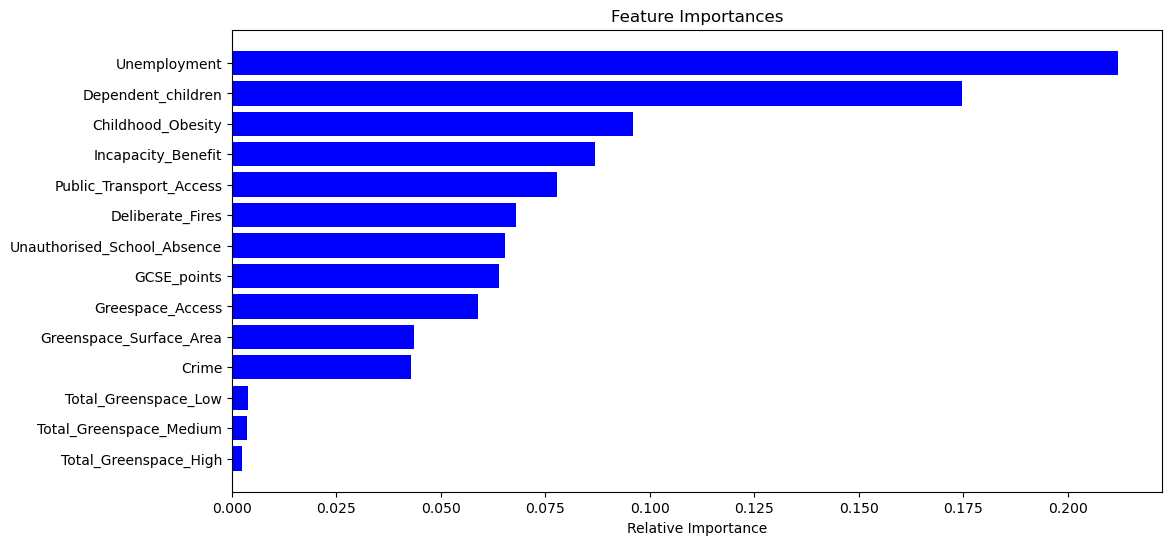

In [100]:
features = f2
importances = gb_model.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


# Conclusion:

In [ ]:
The Gradient Boosting Regression model was the best of the models I tested. 